In [128]:
# --- [1] Imports and Setup ---
import matplotlib.pyplot as plt
import cv2
import numpy as np
import json
import os
from utility import stereo_utils as su

# %matplotlib inline

In [ ]:
# --- [2] Global Variables ---
JSON_PATH = "development_calibration.json"
CHESSBOARD_SIZE = (18, 12)
FRAME_WIDTH = 1280
FRAME_HEIGHT = 480
IMG_SOURCE = "development/left/left_00.jpg"  # Change if needed

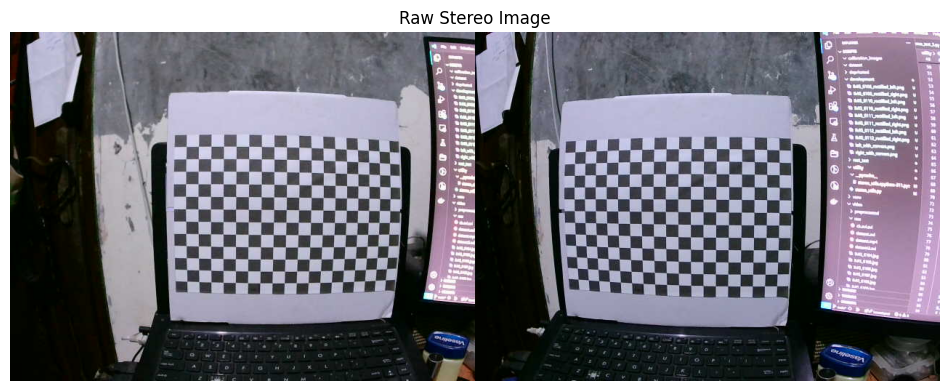

In [130]:
# --- [3] Load and Show Raw Stereo Image ---
frame = cv2.imread(IMG_SOURCE)
frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)  # Convert for matplotlib

plt.figure(figsize=(12,6))
plt.title("Raw Stereo Image")
plt.imshow(frame_rgb)
plt.axis('off')
plt.show()

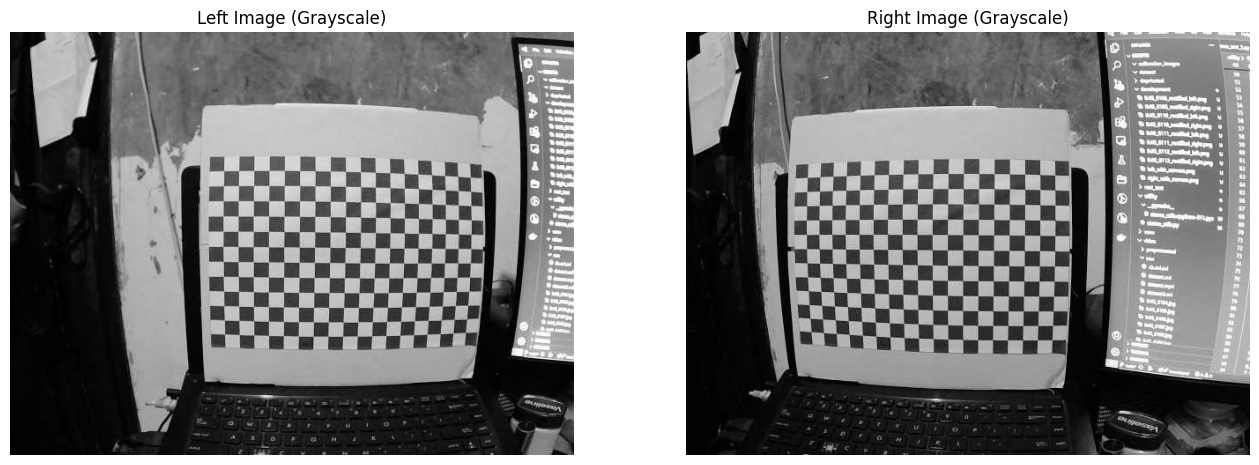

In [131]:
# --- [4] Preprocessing: Split and Grayscale ---
frame = cv2.imread(IMG_SOURCE)
left_img, right_img = su.Split_Stereo_Frame(frame)

left_img = su.Convert_to_Grayscale(left_img)
right_img = su.Convert_to_Grayscale(right_img)

# left_img = cv2.equalizeHist(left_img)
# right_img = cv2.equalizeHist(right_img)

# Show split images
fig, axes = plt.subplots(1, 2, figsize=(16,6))
axes[0].imshow(left_img, cmap='gray')
axes[0].set_title('Left Image (Grayscale)')
axes[0].axis('off')
axes[1].imshow(right_img, cmap='gray')
axes[1].set_title('Right Image (Grayscale)')
axes[1].axis('off')
plt.show()

Saved Left Chessboard Corners Image at: development\left_with_corners.png
Saved Right Chessboard Corners Image at: development\right_with_corners.png


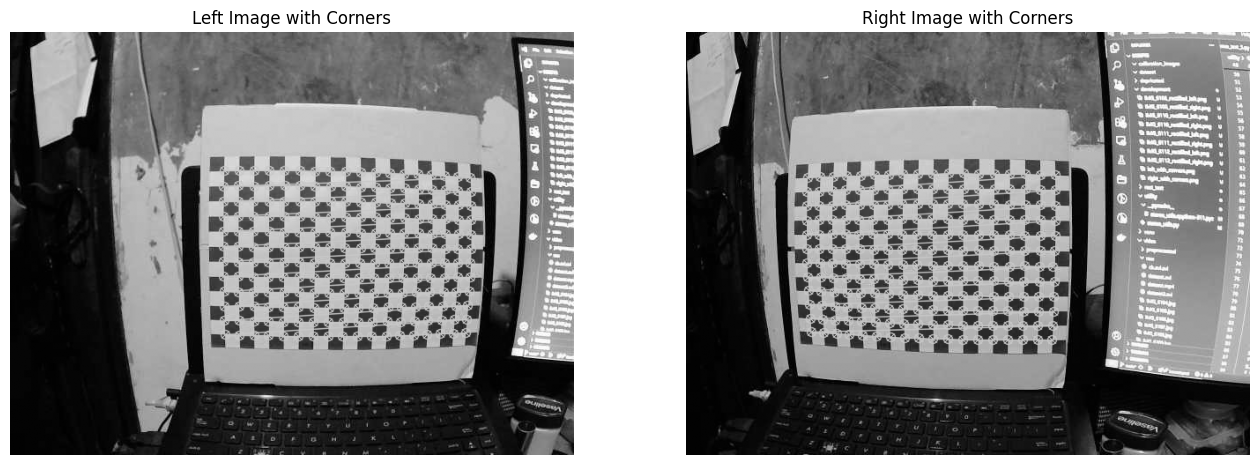

In [132]:
# --- [5] Detect Chessboard Corners ---
ret_l, corners_l = cv2.findChessboardCorners(left_img, CHESSBOARD_SIZE, None)
ret_r, corners_r = cv2.findChessboardCorners(right_img, CHESSBOARD_SIZE, None)

# Draw detected corners
left_with_corners = cv2.drawChessboardCorners(left_img.copy(), CHESSBOARD_SIZE, corners_l, ret_l)
right_with_corners = cv2.drawChessboardCorners(right_img.copy(), CHESSBOARD_SIZE, corners_r, ret_r)

# --- Save images to /development/ folder ---
save_folder = "development"
os.makedirs(save_folder, exist_ok=True)  # Create the folder if it doesn't exist

left_save_path = os.path.join(save_folder, "left_with_corners.png")
right_save_path = os.path.join(save_folder, "right_with_corners.png")

cv2.imwrite(left_save_path, left_with_corners)
cv2.imwrite(right_save_path, right_with_corners)

print(f"Saved Left Chessboard Corners Image at: {left_save_path}")
print(f"Saved Right Chessboard Corners Image at: {right_save_path}")

# --- Show images inline ---
fig, axes = plt.subplots(1, 2, figsize=(16,6))
axes[0].imshow(left_with_corners, cmap='gray')
axes[0].set_title('Left Image with Corners')
axes[0].axis('off')

axes[1].imshow(right_with_corners, cmap='gray')
axes[1].set_title('Right Image with Corners')
axes[1].axis('off')

plt.show()


In [133]:
# --- [6] Stereo Calibration ---
objp = np.zeros((CHESSBOARD_SIZE[0]*CHESSBOARD_SIZE[1], 3), np.float32)
objp[:, :2] = np.mgrid[0:CHESSBOARD_SIZE[0], 0:CHESSBOARD_SIZE[1]].T.reshape(-1, 2)
objpoints = [objp]
imgpoints_left = [corners_l]
imgpoints_right = [corners_r]
image_size = left_img.shape[::-1]

criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 1e-5)
flags = 0  # No CALIB_FIX_INTRINSIC

retval, mtx_l, dist_l, mtx_r, dist_r, R, T, E, F = cv2.stereoCalibrate(
    objpoints, imgpoints_left, imgpoints_right,
    None, None, None, None,
    image_size,
    criteria=criteria,
    flags=flags
)

print("[Stereo_Calibrate] Calibration complete.")


[Stereo_Calibrate] Calibration complete.


In [134]:
# --- [7] Stereo Rectification ---
R1, R2, P1, P2, Q, _, _ = cv2.stereoRectify(
    mtx_l, dist_l, mtx_r, dist_r,
    image_size, R, T, alpha=0
)

# Save calibration results
calib_data = {
    "mtx_left": mtx_l.tolist(),
    "dist_left": dist_l.tolist(),
    "mtx_right": mtx_r.tolist(),
    "dist_right": dist_r.tolist(),
    "R": R.tolist(),
    "T": T.tolist(),
    "E": E.tolist(),
    "F": F.tolist(),
    "R1": R1.tolist(),
    "R2": R2.tolist(),
    "P1": P1.tolist(),
    "P2": P2.tolist(),
    "Q": Q.tolist(),
    "image_size": image_size
}

with open(JSON_PATH, "w") as f:
    json.dump(calib_data, f, indent=4)

print(f"[Saved] Calibration parameters saved to {JSON_PATH}")

[Saved] Calibration parameters saved to development_calibration.json


In [135]:
# --- [8] Undistort and Rectify Images ---
def draw_scanlines(img, color=(0,255,0), interval=40):
    img_color = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
    for y in range(0, img.shape[0], interval):
        cv2.line(img_color, (0,y), (img.shape[1],y), color, 1)
    return img_color

Saved Rectified Left Image at: development\IMG_6113_rectified_left.png
Saved Rectified Right Image at: development\IMG_6113_rectified_right.png


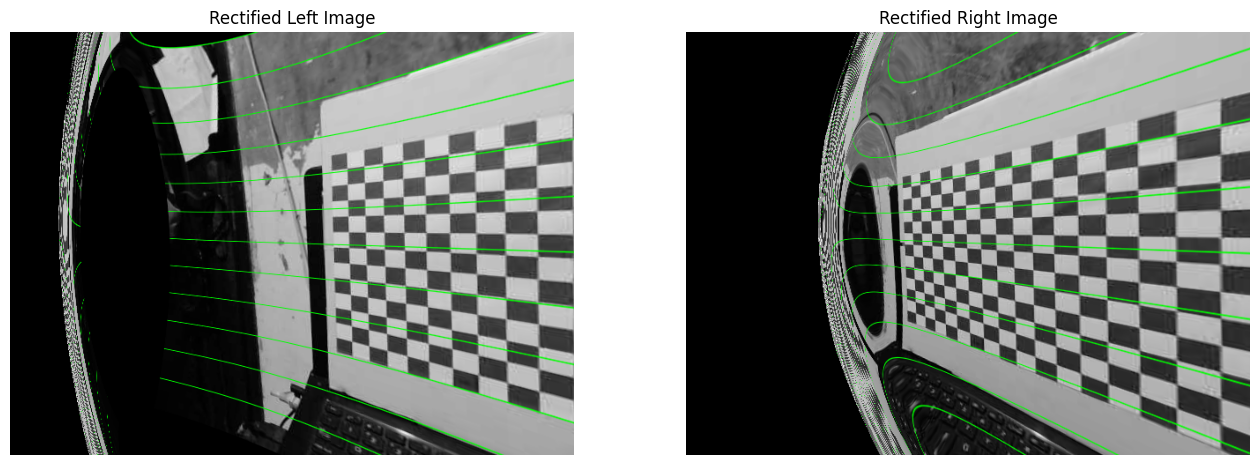

In [136]:
# --- [7] Prepare Images with Scanlines ---
left_img_sc = draw_scanlines(left_img)
right_img_sc = draw_scanlines(right_img)

# --- [8] Undistort and Rectify without Cropping ---
h, w = left_img.shape  # (height, width)

left_map1, left_map2 = cv2.initUndistortRectifyMap(
    mtx_l, dist_l, R1, mtx_l, (w, h), cv2.CV_16SC2)  # Use mtx_l instead of P1
right_map1, right_map2 = cv2.initUndistortRectifyMap(
    mtx_r, dist_r, R2, mtx_r, (w, h), cv2.CV_16SC2)  # Use mtx_r instead of P2

rectified_left = cv2.remap(left_img_sc, left_map1, left_map2, cv2.INTER_LINEAR)
rectified_right = cv2.remap(right_img_sc, right_map1, right_map2, cv2.INTER_LINEAR)

# --- Save Rectified Images ---
save_folder = "development"
os.makedirs(save_folder, exist_ok=True)

base_name = os.path.splitext(os.path.basename(IMG_SOURCE))[0]  # 'IMG_6104'

rectified_left_path = os.path.join(save_folder, f"{base_name}_rectified_left.png")
rectified_right_path = os.path.join(save_folder, f"{base_name}_rectified_right.png")

cv2.imwrite(rectified_left_path, rectified_left)
cv2.imwrite(rectified_right_path, rectified_right)

print(f"Saved Rectified Left Image at: {rectified_left_path}")
print(f"Saved Rectified Right Image at: {rectified_right_path}")

# --- Show Rectified Images Inline ---
fig, axes = plt.subplots(1, 2, figsize=(16,6))
axes[0].imshow(rectified_left, cmap='gray')
axes[0].set_title('Rectified Left Image')
axes[0].axis('off')

axes[1].imshow(rectified_right, cmap='gray')
axes[1].set_title('Rectified Right Image')
axes[1].axis('off')

plt.show()
